In [1]:
# Imports
import torch
import torchvision  # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For a nice progress bar!

In [8]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# Hyperparameters
input_size = 28
hidden_size = 256
num_layers = 2
num_classes = 10
sequence_length = 28
learning_rate = 0.005
batch_size = 64
num_epochs = 3

In [10]:
# Recurrent neural network (many-to-one)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_length, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.rnn(x, h0)
        out = out.reshape(out.shape[0], -1)

        # Decode the hidden state of the last time step
        out = self.fc(out)
        return out

In [11]:
# Recurrent neural network with GRU (many-to-one)
class RNN_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN_GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_length, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.gru(x, h0)
        out = out.reshape(out.shape[0], -1)

        # Decode the hidden state of the last time step
        out = self.fc(out)
        return out


In [12]:
# Recurrent neural network with LSTM (many-to-one)
class RNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_length, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.lstm(
            x, (h0, c0)
        )  # out: tensor of shape (batch_size, seq_length, hidden_size)
        out = out.reshape(out.shape[0], -1)

        # Decode the hidden state of the last time step
        out = self.fc(out)
        return out

In [13]:
# Load Data
train_dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST\raw\train-images-idx3-ubyte.gz to dataset/MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST\raw\train-labels-idx1-ubyte.gz to dataset/MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST\raw\t10k-images-idx3-ubyte.gz to dataset/MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST\raw\t10k-labels-idx1-ubyte.gz to dataset/MNIST\raw



In [14]:
# Initialize network (try out just using simple RNN, or GRU, and then compare with LSTM)
model = RNN_LSTM(input_size, hidden_size, num_layers, num_classes).to(device)


In [15]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
model

RNN_LSTM(
  (lstm): LSTM(28, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=7168, out_features=10, bias=True)
)

In [17]:
# Train Network
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device).squeeze(1)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent update step/adam step
        optimizer.step()

100%|██████████| 938/938 [00:06<00:00, 143.25it/s]


In [18]:
# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0

    # Set model to eval
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device).squeeze(1)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    # Toggle model back to train
    model.train()
    return num_correct / num_samples

In [19]:
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")

Accuracy on training set: 99.216667
Accuracy on test set: 98.98


In [20]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: dataset/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [24]:
import matplotlib.pyplot as plt

In [23]:
train_dataset.data[0]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], dtype=torch.uint8)

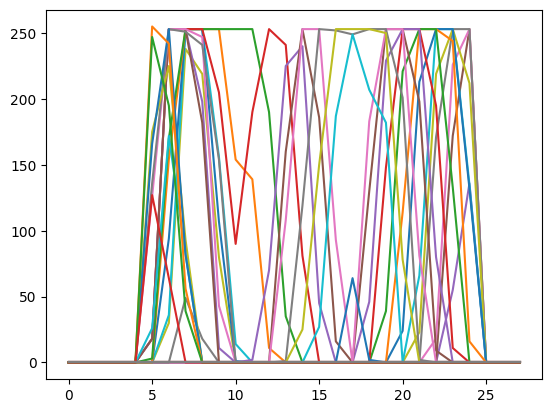

In [25]:
plt.plot(train_dataset.data[0])